<a href="https://colab.research.google.com/drive/1C89w7DsediH-9QDgu132fL520tWRJ5FU?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ динамики продуктовой воронки Тинькофф Квест

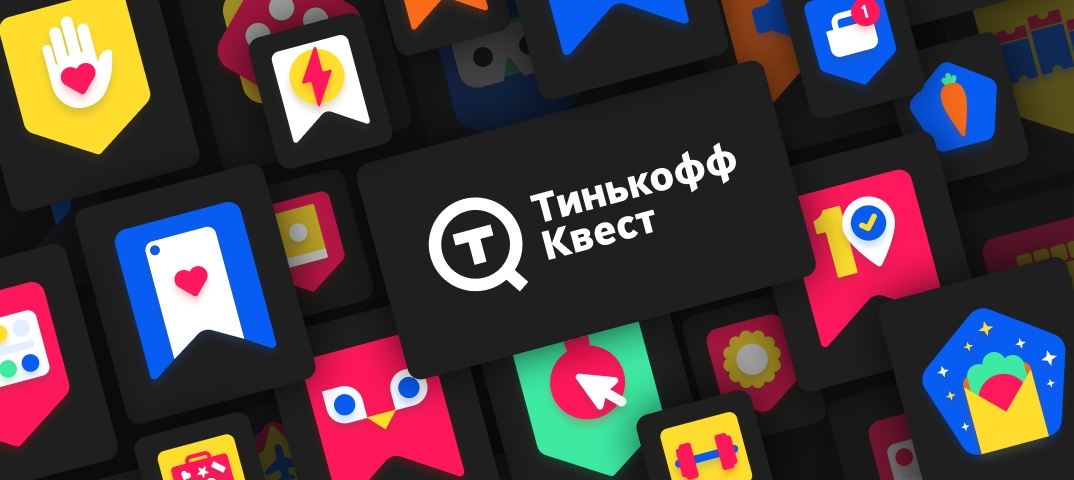

**Содержание** <a class='anchor' id='table_of_contents'></a>

* [Описание проекта](#description)
* [Описание данных](#data)
* [Шаг 1. Выгрузка данных из БД](#step_1)
* [Шаг 2. Предобработка данных](#step_2)
* [Шаг 3. Визуализация данных](#step_3)
    * [Общая воронка](#step_3_1)
    * [Воронка в разбивке по неделям](#step_3_2)
    * [Воронка в разбивке по месяцам](#step_3_3)
* [Выводы](#final)

## Описание проекта <a class='anchor' id='description'></a>

Для того чтобы отслеживать, как выглядит путь клиента от знакомства с продуктом до его получения, и какие в нем есть проблемные места, аналитики часто строят воронки. Этот инструмент позволяет понять, сколько клиентов "теряется" на каждом из этапов процесса и сколько в итоге совершает целевое действие.

В нашем распоряжении схема данных проекта Тинькофф Квест. Необходимо построить воронку, которая показывала бы в динамике по неделям и месяцам, сколько клиентов посещает сайт, и какая доля из них регистрируется на нем, подает заявку на игру и по факту приходит на нее. Количество клиентов и конверсии необходимо изобразить на одном графике.

Исходя из построенных воронок необходимо сделать выводы и определить возможные точки роста продукта.

## Описание данных <a class='anchor' id='data'></a>

В проекте будут использоваться таблицы `game`, `client`, `account` и `application` из базы данных `msu_analytics`.

**Game**

Витрина с расписанием запланированных и состоявшихся игр (отдельных прохождений и просто слотов в расписании по играм).

| Название поля | Описание                                        |
| ------------- | ----------------------------------------------- |
| Game_rk       | Ключ отдельной игры в хранилище данных          |
| Quest_rk      | Ключ квест, в рамках которого проходила игра    |
| Employee_rk   | Ключ сотрудника, который проводил игру          |
| Game_dttm     | Дата-время запланированного начала игры         |
| Price         | Стоимость игры                                  |
| Game_flg      | Флаг того, что игра состоялась                  |
| Finish_flg    | Флаг того, что состоявшуюся игру удалось пройти |
| Time          | Время прохождения игры                          |

**Client**

Витрина содержит информацию о клиентах, посетивших наш сайт.

| Название поля | Описание                                            |
| ------------- | --------------------------------------------------- |
| Client_rk     | Ключ клиента в ХД                                   |
| First_name    | Имя клиента                                         |
| Last_name     | Фамилия клиента                                     |
| Phone_num     | Номер телефона                                      |
| Visit_dttm    | Дата и время, когда клиент крайний раз посещал сайт |

**Account**

Витрина содержит информацию об аккаунтах клиентов (если у клиента есть аккаунт, значит он зарегистрировался на сайте).

| Название поля     | Описание                                  |
| ----------------- | ----------------------------------------- |
| Account_rk        | Ключ аккаунта клиента в ХД                |
| Client_rk         | Ключ клиента в ХД                         |
| Registration_dttm | Дата и время регистрации клиента на сайте |
| Login             | Логин зарегистрированного клиента         |
| Password          | Пароль зарегистрированного клиента        |
| Email             | Адрес электронной почты клиента           |

**Application**

Витрина содержит информацию о заявках клиентов на игры (заявку может оставить только авторизованный клиент, также разные клиенты могут оставить заявку на одну и ту же игру).

| Название поля    | Описание                            |
| ---------------- | ----------------------------------- |
| Application_rk   | Ключ заявки в ХД                    |
| Account_rk       | Ключ аккаунта клиента в ХД          |
| Client_rk        | Ключ клиента в ХД                   |
| Application_dttm | Дата и время заявки на игру клиента |

[Назад к содержанию](#table_of_contents)

## Шаг 1. Выгрузка данных из БД <a class='anchor' id='step_1'></a>

Загрузим все необходимые функции и библиотеки.

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import plotly.express as px
from plotly import graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

pd.set_option('display.max_columns', None)

In [2]:
# функция для подсчета дубликатов и получения общих сведений о датасете
def get_info(data):
    display(data.head())
    print()
    print('Число дубликатов:', data.duplicated().sum())
    print()
    data.info()

In [3]:
# функция для подсчета доли пропусков
def get_na(data):
    na_info = (
        pd.DataFrame(data.isna().mean())
        .rename(columns={0: 'NaN'})
        .style
        .set_caption('Доля пропусков')
        .background_gradient('coolwarm')
        .format('{:.2%}')
        )
    return na_info

Установим подключение к базе данных.

In [4]:
# устанавливаем параметры
db_config = {'user': 'student', # имя пользователя
'pwd': 'JvLda93aA', # пароль
'host': '158.160.52.106',
'port': 5432, # порт подключения
'db': 'postgres'} # название базы данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
 db_config['pwd'],
 db_config['host'],
 db_config['port'],
 db_config['db'])

# сохраняем коннектор
engine = create_engine(connection_string) 

In [5]:
def select(sql):
  return pd.read_sql(sql, con=engine)

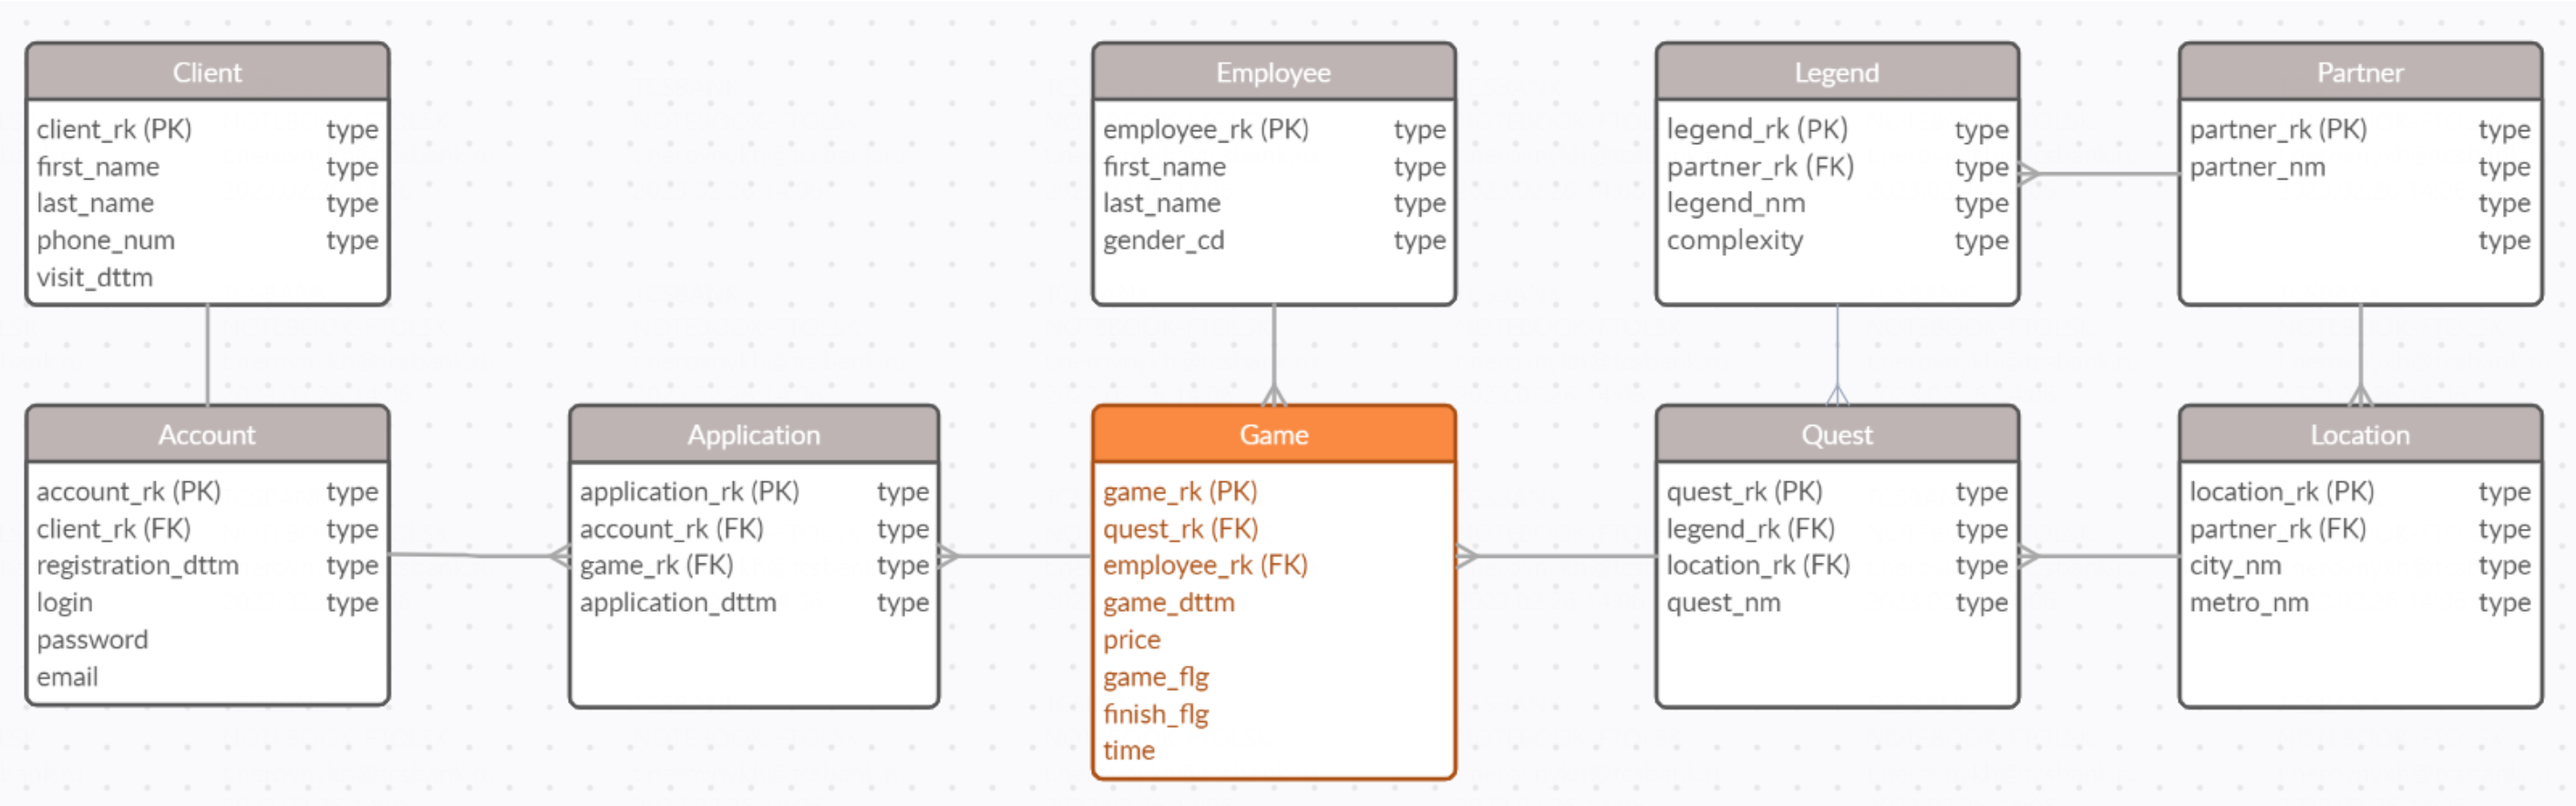

Рассмотрим необходимые таблицы и сделаем к ним по одному запросу.

In [6]:
sql = '''
select * from msu_analytics.client limit 5
'''

select(sql)

,client_rk,first_name,last_name,phone_num,visit_dttm
0,73,Вера,Зуева,+79526387110,2022-10-28 03:05:45.702007
1,153,Никита,Гаврилов,+79517529539,2022-10-02 17:52:15.398456
2,169,Изольда,Калашникова,+79026008294,2022-10-03 17:11:41.108703
3,249,Клим,Носов,+79536437636,2022-10-29 07:39:09.311283
4,318,Гавриил,Белов,+79659279079,2022-12-17 12:37:24.580302


In [7]:
sql = '''select * from msu_analytics.account limit 5'''

select(sql)

,account_rk,client_rk,registration_dttm,login,password,email
0,6,3979,2022-11-14 14:19:58.850038,anaumov,9qbXqTmR6KB,anaumov25@example.org
1,22,3882,2022-09-14 18:49:17.598361,klavdia59,LfFlA4J8U,klavdia595@example.org
2,38,3349,2022-11-29 04:43:36.664249,timur81,2tQELT9F7d,timur8152@example.org
3,54,3422,2023-01-30 20:42:41.309235,veniamin30,L3dVZcXoz,veniamin309@example.net
4,70,439,2023-01-23 22:25:48.196779,aleksandrov.lusa,xDb5nGwZMbrF,aleksandrov.lusa69@example.com


In [8]:
sql = '''select * from msu_analytics.application limit 5'''

select(sql)

,application_rk,account_rk,game_rk,application_dttm
0,220,527,34,2022-12-20 09:08:48.489951
1,375,671,224,2023-01-21 00:44:52.984950
2,471,703,332,2023-01-22 01:57:51.678682
3,108,772,67,2022-12-14 10:12:15.645846
4,279,684,196,2022-11-07 05:43:00.119593


In [9]:
sql = '''select * from msu_analytics.game limit 5'''

select(sql)

,game_rk,quest_rk,employee_rk,game_dttm,price,game_flg,finish_flg,time
0,9,24,4,2022-12-07 03:35:01.504956,1801.54,1,1,16:50:33
1,41,14,10,2023-01-24 00:50:38.029468,1996.72,1,1,04:35:40
2,57,29,8,2022-12-30 01:27:43.771770,2742.21,1,0,04:00:22
3,73,14,10,2022-11-26 12:23:44.323394,1935.05,1,0,06:49:44
4,105,24,16,2023-01-21 19:20:42.404956,1158.44,1,0,20:50:49


Напишем запрос, которые соберет следующую информацию: 
- данные о всех клиентах, заходивших на сайт проекта;
- данные о регистрации на сайте;
- данные о заявках, поданных на игры;
- сведения о том, когда состоялись игры.

In [10]:
sql = '''
select c.client_rk,
       c.first_name,
       c.last_name,
       c.visit_dttm,

       a.account_rk,
       a.registration_dttm,
       a.email,

       app.application_rk,
       app.application_dttm,
       
       g.game_rk,
       g.game_dttm,
       g.game_flg,
       g.finish_flg


from msu_analytics.client c
left join msu_analytics.account a on c.client_rk = a.client_rk
left join msu_analytics.application app on a.account_rk = app.account_rk
left join msu_analytics.game g on app.game_rk = g.game_rk
'''

select(sql)

,client_rk,first_name,last_name,visit_dttm,account_rk,registration_dttm,email,application_rk,application_dttm,game_rk,game_dttm,game_flg,finish_flg
0,1963,Ольга,Королёва,2023-01-30 07:51:00.017225,876.0,2023-01-30 17:09:50.530144,nika.muravev81@example.net,NaN,NaT,NaN,NaT,NaN,NaN
1,2628,Галина,Гусева,2022-09-28 17:56:24.207648,113.0,2022-09-29 08:57:08.744683,konovalova.ananij2@example.net,NaN,NaT,NaN,NaT,NaN,NaN
2,3581,Людмила,Евсеева,2022-09-25 16:17:55.912678,647.0,2022-09-26 13:35:09.407616,eva.zuravlev53@example.net,NaN,NaT,NaN,NaT,NaN,NaN
3,38,Иммануил,Кулагин,2022-11-05 10:36:09.881236,NaN,NaT,None,NaN,NaT,NaN,NaT,NaN,NaN
4,54,Семён,Дроздов,2022-11-02 02:21:36.897385,NaN,NaT,None,NaN,NaT,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4310,4012,Вениамин,Коновалов,2022-12-26 18:24:59.777824,NaN,NaT,None,NaN,NaT,NaN,NaT,NaN,NaN
4311,4028,Спартак,Мишин,2022-09-06 23:59:44.010226,NaN,NaT,None,NaN,NaT,NaN,NaT,NaN,NaN
4312,4060,Юрий,Молчанов,2022-12-03 09:26:59.002041,NaN,NaT,None,NaN,NaT,NaN,NaT,NaN,NaN
4313,4076,Фаина,Анисимова,2022-11-25 14:38:18.131704,NaN,NaT,None,NaN,NaT,NaN,NaT,NaN,NaN


Полученную таблицу запишем в датафрейм `data`.

In [11]:
data = select(sql)

Рассмотрим типы данных в полученном датасете `data`, а также проверим в нем количество пропусков и дубликатов.

In [12]:
get_info(data)

,client_rk,first_name,last_name,visit_dttm,account_rk,registration_dttm,email,application_rk,application_dttm,game_rk,game_dttm,game_flg,finish_flg
0,478,Артём,Авдеев,2022-09-18 09:02:15.622278,406.0,2022-09-19 04:06:48.824524,belozerov.timofej27@example.org,NaN,NaT,NaN,NaT,NaN,NaN
1,591,Глеб,Семёнов,2022-09-06 13:12:56.542908,326.0,2022-09-06 22:24:45.361836,albert9195@example.net,NaN,NaT,NaN,NaT,NaN,NaN
2,772,Клим,Тихонов,2023-01-15 00:44:04.570005,358.0,2023-01-15 18:30:13.206379,anisimov.nina23@example.org,NaN,NaT,NaN,NaT,NaN,NaN
3,41,Доминика,Терентьева,2022-12-07 15:13:13.343434,NaN,NaT,None,NaN,NaT,NaN,NaT,NaN,NaN
4,57,Иннокентий,Мишин,2022-11-30 12:03:46.625687,NaN,NaT,None,NaN,NaT,NaN,NaT,NaN,NaN



Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4315 entries, 0 to 4314
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   client_rk          4315 non-null   int64         
 1   first_name         4315 non-null   object        
 2   last_name          4315 non-null   object        
 3   visit_dttm         4315 non-null   datetime64[ns]
 4   account_rk         1243 non-null   float64       
 5   registration_dttm  1243 non-null   datetime64[ns]
 6   email              1243 non-null   object        
 7   application_rk     512 non-null    float64       
 8   application_dttm   512 non-null    datetime64[ns]
 9   game_rk            512 non-null    float64       
 10  game_dttm          512 non-null    datetime64[ns]
 11  game_flg           512 non-null    float64       
 12  finish_flg         512 non-null    float64       
dtypes: datetime64[ns](4), float64(5), int64(1

Проверим датасет на наличие пропусков.

In [13]:
get_na(data)

,NaN
client_rk,0.00%
first_name,0.00%
last_name,0.00%
visit_dttm,0.00%
account_rk,71.19%
registration_dttm,71.19%
email,71.19%
application_rk,88.13%
application_dttm,88.13%
game_rk,88.13%


В датасете обнаружено большое количество пропусков, возникновение которых связано с характером соединения таблиц (left join). Заполнять пропуски нет необходимости.

Посмотрим, какой период охватывают данные.

In [14]:
print('Самая ранняя дата:', data['visit_dttm'].min())
print('Самая поздняя дата:', data['visit_dttm'].max())

Самая ранняя дата: 2022-09-01 03:32:43.977277
Самая поздняя дата: 2023-02-02 02:22:04.176738


Данные охватывают период с 1 сентября 2022 года по 2 февраля 2023 года.

[Назад к содержанию](#table_of_contents)

## Шаг 2. Предобработка данных <a class='anchor' id='step_2'></a>

Создадим столбцы с номерами недель, месяцев и годом в датафрейме `data` для удобства в дальнейшей группировке.

In [15]:
data['visit_dttm_week'] = data['visit_dttm'].dt.isocalendar().week
data['visit_dttm_month'] = data['visit_dttm'].dt.month
data['visit_year'] = data['visit_dttm'].dt.year

In [16]:
data.head()

,client_rk,first_name,last_name,visit_dttm,account_rk,registration_dttm,email,application_rk,application_dttm,game_rk,game_dttm,game_flg,finish_flg,visit_dttm_week,visit_dttm_month,visit_year
0,478,Артём,Авдеев,2022-09-18 09:02:15.622278,406.0,2022-09-19 04:06:48.824524,belozerov.timofej27@example.org,NaN,NaT,NaN,NaT,NaN,NaN,37,9,2022
1,591,Глеб,Семёнов,2022-09-06 13:12:56.542908,326.0,2022-09-06 22:24:45.361836,albert9195@example.net,NaN,NaT,NaN,NaT,NaN,NaN,36,9,2022
2,772,Клим,Тихонов,2023-01-15 00:44:04.570005,358.0,2023-01-15 18:30:13.206379,anisimov.nina23@example.org,NaN,NaT,NaN,NaT,NaN,NaN,2,1,2023
3,41,Доминика,Терентьева,2022-12-07 15:13:13.343434,NaN,NaT,None,NaN,NaT,NaN,NaT,NaN,NaN,49,12,2022
4,57,Иннокентий,Мишин,2022-11-30 12:03:46.625687,NaN,NaT,None,NaN,NaT,NaN,NaT,NaN,NaN,48,11,2022


Создадим датафрейм `clients_weekly`, в котором в разбивке по неделям подсчитаем уникальное количество визитов, регистраций, заявок и игр.

In [17]:
clients_weekly = pd.pivot_table(data, 
                 index=['visit_dttm_week'], 
                 values=['client_rk', 'account_rk', 'application_rk', 'game_rk'], 
                 aggfunc='nunique').reset_index()

In [18]:
clients_weekly.head()

,visit_dttm_week,account_rk,application_rk,client_rk,game_rk
0,1,58,27,201,26
1,2,47,23,205,23
2,3,43,21,181,21
3,4,41,29,182,28
4,5,22,6,81,6


Создадим датафрейм `games_weekly`, в котором в разбивке по неделям подсчитаем количество запланированных и состоявшихся игр.

In [19]:
games_weekly = pd.pivot_table(data, 
               index=['visit_dttm_week'], 
               values=['game_flg', 'finish_flg'], 
               aggfunc='sum').reset_index()

Соединим датафреймы `games_weekly` и `clients_weekly`. Укажем нужную очередность столбцов в результирующем датасете.

In [20]:
funnel_weekly = clients_weekly.merge(games_weekly, on='visit_dttm_week', how='left')[['visit_dttm_week', 
                                                                                      'client_rk', 
                                                                                      'account_rk', 
                                                                                      'application_rk', 
                                                                                      'game_rk', 
                                                                                      'game_flg', 
                                                                                      'finish_flg']]

In [21]:
funnel_weekly.head()

,visit_dttm_week,client_rk,account_rk,application_rk,game_rk,game_flg,finish_flg
0,1,201,58,27,26,4.0,3.0
1,2,205,47,23,23,6.0,4.0
2,3,181,43,21,21,5.0,3.0
3,4,182,41,29,28,5.0,3.0
4,5,81,22,6,6,0.0,0.0


В столбце `year` проставим год для каждой из недель во избежание путаницы. Вставим столбец в начале датафрейма `funnel_weekly`.

In [22]:
funnel_weekly.insert(1, 'year', funnel_weekly['visit_dttm_week'].apply(lambda x: 2022 if x >=35 else 2023))
funnel_weekly = funnel_weekly.astype({'game_flg':'int32', 'finish_flg': 'int32'})
funnel_weekly = funnel_weekly.sort_values(by=['year', 'visit_dttm_week'])

Создадим строковый столбец с меткой о номере недели и года в формате `неделя_год`.

In [23]:
funnel_weekly['visit_dttm_week_year'] = funnel_weekly['visit_dttm_week'].astype('str') + '_' + funnel_weekly['year'].astype('str')

In [24]:
funnel_weekly.head()

,visit_dttm_week,year,client_rk,account_rk,application_rk,game_rk,game_flg,finish_flg,visit_dttm_week_year
5,35,2022,111,32,15,14,8,3,35_2022
6,36,2022,184,31,9,9,6,2,36_2022
7,37,2022,167,43,27,25,11,5,37_2022
8,38,2022,181,45,21,20,18,12,38_2022
9,39,2022,195,59,34,33,26,10,39_2022


Расчитаем конверсию для каждой недели в столбце `conversion`.

In [25]:
funnel_weekly = funnel_weekly.assign(conversion=funnel_weekly['finish_flg'] / funnel_weekly['client_rk'])

In [26]:
funnel_weekly.style.format({'conversion':'{:.2%}'})

,visit_dttm_week,year,client_rk,account_rk,application_rk,game_rk,game_flg,finish_flg,visit_dttm_week_year,conversion
5,35,2022,111,32,15,14,8,3,35_2022,2.70%
6,36,2022,184,31,9,9,6,2,36_2022,1.09%
7,37,2022,167,43,27,25,11,5,37_2022,2.99%
8,38,2022,181,45,21,20,18,12,38_2022,6.63%
9,39,2022,195,59,34,33,26,10,39_2022,5.13%
10,40,2022,204,58,27,27,22,9,40_2022,4.41%
11,41,2022,190,44,20,19,17,9,41_2022,4.74%
12,42,2022,171,41,20,20,14,8,42_2022,4.68%
13,43,2022,189,48,27,25,11,2,43_2022,1.06%
14,44,2022,197,47,31,31,23,14,44_2022,7.11%


Аналогичным образом, в датафрейме `games_monthly` рассчитаем значения воронки и конверсии в разбивке по месяцам.

In [27]:
games_monthly = pd.pivot_table(data, 
                index=['visit_dttm_month'], 
                values=['game_flg', 'finish_flg'], 
                aggfunc='sum').reset_index()

In [28]:
clients_monthly = pd.pivot_table(data, 
                  index=['visit_dttm_month'], 
                  values=['client_rk', 'account_rk', 'application_rk', 'game_rk'], 
                  aggfunc='nunique').reset_index()

Выполним слияние данных о клиентах и играх в единый датафрейм `funnel_monthly`.

In [29]:
funnel_monthly = clients_monthly.merge(games_monthly, on='visit_dttm_month', how='left')[['visit_dttm_month', 
                                                                                          'client_rk', 
                                                                                          'account_rk', 
                                                                                          'application_rk', 
                                                                                          'game_rk', 
                                                                                          'game_flg', 
                                                                                          'finish_flg']]

В столбце `year` проставим год для каждого из месяцев. Вставим столбец в начале датафрейма `funnel_monthly`.

In [30]:
funnel_monthly.insert(1, 'year', funnel_monthly['visit_dttm_month'].apply(lambda x: 2022 if x >=9 else 2023))
funnel_monthly = funnel_monthly.astype({'game_flg':'int32', 'finish_flg': 'int32'})
funnel_monthly = funnel_monthly.sort_values(by=['year', 'visit_dttm_month'])

Рассчитаем конверсию для каждого месяца.

In [31]:
funnel_monthly = funnel_monthly.assign(conversion=funnel_monthly['finish_flg'] / funnel_monthly['client_rk'])

In [32]:
funnel_monthly['month_year'] = funnel_monthly['visit_dttm_month'].astype('str') + '_' + funnel_monthly['year'].astype('str')

In [33]:
funnel_monthly.style.format({'conversion':'{:.2%}'})

,visit_dttm_month,year,client_rk,account_rk,application_rk,game_rk,game_flg,finish_flg,conversion,month_year
2,9,2022,778,190,91,81,59,28,3.60%,9_2022
3,10,2022,843,217,109,98,74,32,3.80%,10_2022
4,11,2022,786,200,101,90,71,39,4.96%,11_2022
5,12,2022,805,196,100,87,39,20,2.48%,12_2022
0,1,2023,852,213,111,104,21,14,1.64%,1_2023
1,2,2023,32,8,0,0,0,0,0.00%,2_2023


В датафрейме `total_funnel` рассчитаем значения общей воронки и конверсии за весь период.

In [34]:
total_funnel = pd.concat([pd.DataFrame(data[['client_rk', 'account_rk', 'application_rk', 'game_rk']].nunique()), 
                          pd.DataFrame(data[['game_flg', 'finish_flg']].sum())], axis=0)

In [35]:
total_funnel = total_funnel.reset_index().rename(columns={0:'total', 'index':'event'}).astype({'total':'int32'})

In [36]:
total_funnel['conversion'] = total_funnel['total'] / data['client_rk'].nunique()

In [37]:
total_funnel.style.format({'conversion':'{:.2%}'})

,event,total,conversion
0,client_rk,4096,100.00%
1,account_rk,1024,25.00%
2,application_rk,512,12.50%
3,game_rk,315,7.69%
4,game_flg,264,6.45%
5,finish_flg,133,3.25%


[Назад к содержанию](#table_of_contents)

## Шаг 3. Визуализация данных <a class='anchor' id='step_3'></a>

### Общая воронка <a class='anchor' id='step_3_1'></a>

События распределяются следующим образом:
- `client_rk` - количество клиентов, посетивших сайт;
- `account_rk` - количество зарегистрировавшихся пользователей;
- `application_rk` - количество поданных заявок на игры;
- `game_rk` - количество запланированных игр;
- `game_flg` - количество состоявшихся игр;
- `finish_flg` - количество пройденых до конца игр.

In [38]:
total_funnel.style.format({'conversion':'{:.2%}'})

,event,total,conversion
0,client_rk,4096,100.00%
1,account_rk,1024,25.00%
2,application_rk,512,12.50%
3,game_rk,315,7.69%
4,game_flg,264,6.45%
5,finish_flg,133,3.25%


Построим общую воронку.

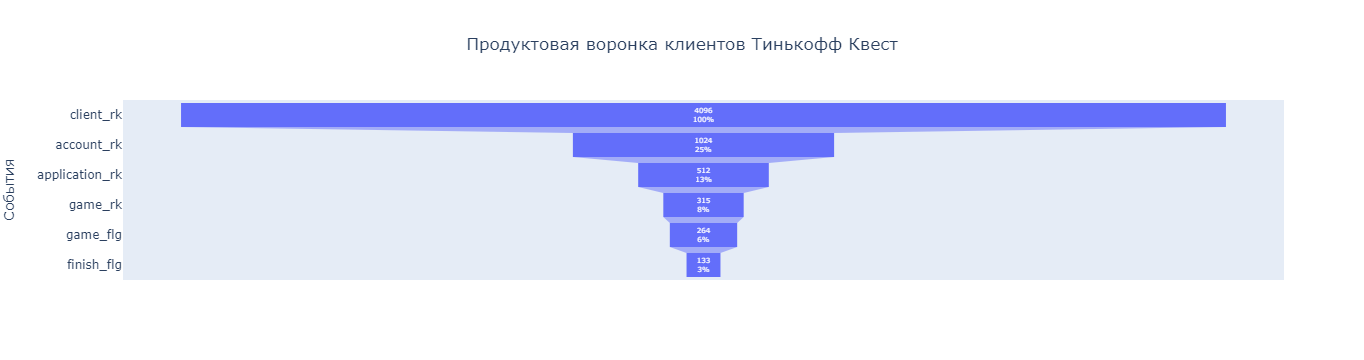

In [39]:
fig = go.Figure(go.Funnel(
    y = total_funnel['event'],
    x = total_funnel['total'],
    textinfo = "value+percent initial"),
    )

fig.update_layout(title_text='Продуктовая воронка клиентов Тинькофф Квест', 
                  title_x=0.5,
                  yaxis_title='События')
fig.show()

Наибольшее количество клиентов теряется при визите на сайт - лишь 25% посетителей регистрируют аккаунт. Для решения этой проблемы необходимо стимулировать клиентов заводить аккаунт. Регистрация должна быть максимально простой и быстрой.

Лишь половина зарегистрировавшихся подают заявки на игры. Возможно, процесс подачи заявки также должна быть упрощена и ускорена.

### Воронка в разбивке по неделям <a class='anchor' id='step_3_2'></a>

Построим график с динамикой продуктовой воронки в разбивке по неделям.

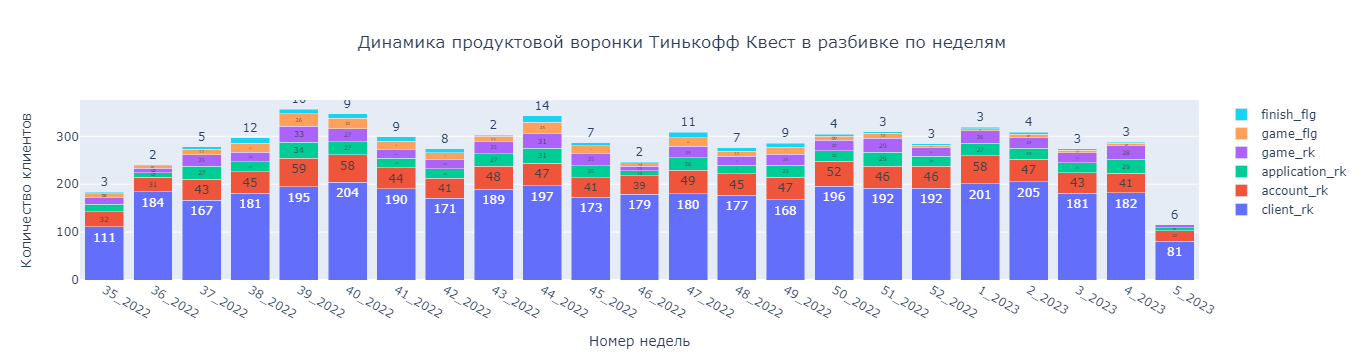

In [40]:
x = funnel_weekly['visit_dttm_week_year']
fig = go.Figure(go.Bar(x=x, y=funnel_weekly['client_rk'], name='client_rk', orientation='v', text=funnel_weekly['client_rk']))

for category in funnel_weekly.loc[:, 'account_rk':'finish_flg']:
    fig.add_trace(go.Bar(x=x, y=funnel_weekly[category], name=category, orientation='v', text=funnel_weekly[category]))

fig.update_layout(barmode='stack')
fig.update_layout(
    title={
        'text': 'Динамика продуктовой воронки Тинькофф Квест в разбивке по неделям',
        'xanchor': 'center',
        'y':0.9,
        'x':0.5},
        xaxis_title='Номер недель',
        yaxis_title='Количество клиентов')

fig.show()

Наибольшее число пройденых игр произошло в те недели, когда приток новых клиентов был максимальным - 39-40 и 44 недели 2022 года. В предновогодние недели приток посетителей сохранялся, но люди не проявляли интерес к играм. Новогодние праздники сильно уменьшили общую конверсию.

Построим график с числом клиентов и их конверсией в пройденные игры.

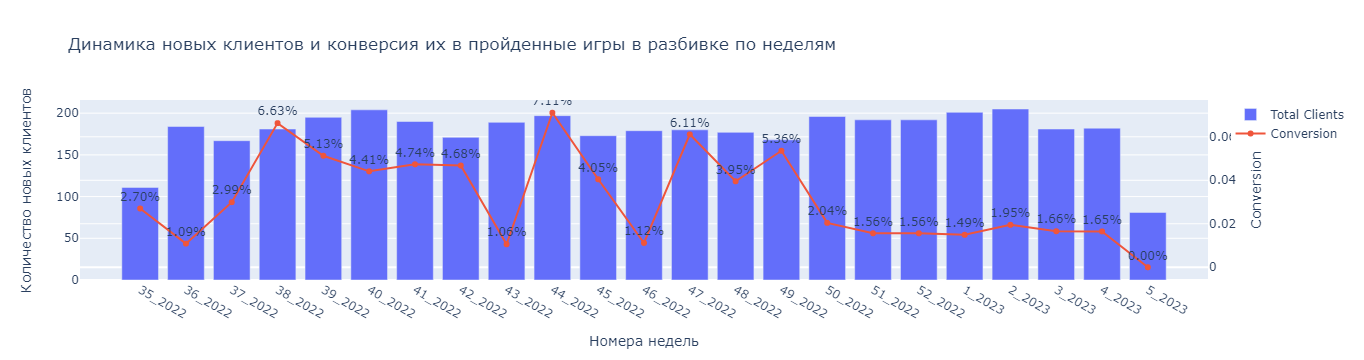

In [41]:
bar_chart = go.Bar(
    x=funnel_weekly['visit_dttm_week_year'],
    y=funnel_weekly['client_rk'],
    name='Total Clients'
)

line_plot = go.Scatter(
    x=funnel_weekly['visit_dttm_week_year'],
    y=funnel_weekly['conversion'],
    name='Conversion',
    yaxis='y2',
    mode='lines+markers+text',
    hovertemplate='Conversion: %{y:.2%}<extra></extra>',
    text = [f'{val:.2%}' for val in funnel_weekly['conversion']],
    textposition='top center'
)

layout = go.Layout(
    title='Динамика новых клиентов и конверсия их в пройденные игры в разбивке по неделям',
    yaxis=dict(title='Количество новых клиентов'),
    xaxis_title='Номера недель',
    yaxis2=dict(
        title='Conversion',
        overlaying='y',
        side='right'
    )
)

fig = go.Figure(data=[bar_chart, line_plot], layout=layout)

fig.show()

Значительное падение конверсии заметно начиная с 50-й недели (декабрь 2022 года) - с 5.36% до 2.0%. В новогодние праздники уровень посещения сайта новыми клиентами сохранялся на уровне 150-200 человек в день, но конверсия стабильно установилась на уровне 1.5-2.0%. На 5-й неделе 2023 года конверсия упала до 0 (февраль 2023). Максимальная конверсия в размере 6.11-7.11% наблюдалась в 38, 44 и 47 недели 2022 года.

### Воронка в разбивке по месяцам <a class='anchor' id='step_3_3'></a>

Данные представлены 6-ю месяцами - с сентября 2022 по февраль 2023.

In [42]:
funnel_monthly

,visit_dttm_month,year,client_rk,account_rk,application_rk,game_rk,game_flg,finish_flg,conversion,month_year
2,9,2022,778,190,91,81,59,28,0.035990,9_2022
3,10,2022,843,217,109,98,74,32,0.037960,10_2022
4,11,2022,786,200,101,90,71,39,0.049618,11_2022
5,12,2022,805,196,100,87,39,20,0.024845,12_2022
0,1,2023,852,213,111,104,21,14,0.016432,1_2023
1,2,2023,32,8,0,0,0,0,0.000000,2_2023


Построим динамику продуктовой воронки в разбивке по месяцам.

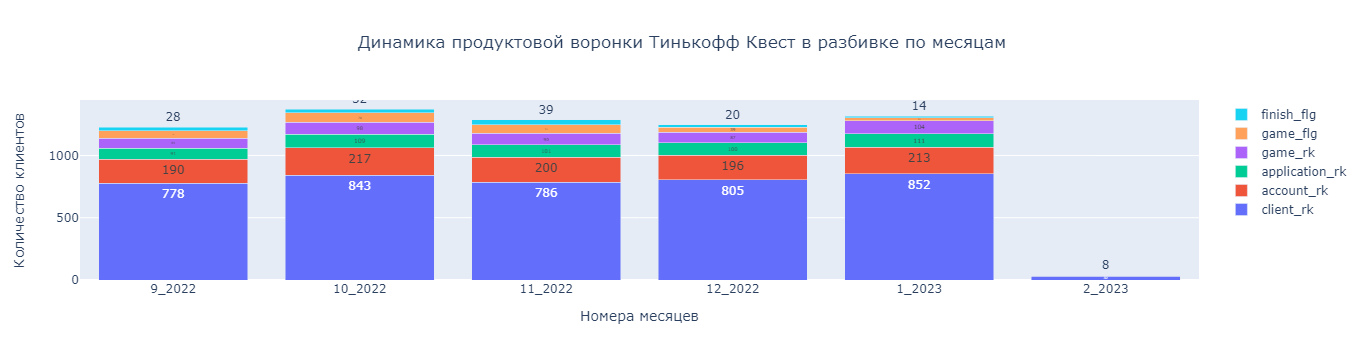

In [43]:
x = funnel_monthly['month_year']
fig = go.Figure(go.Bar(x=x, y=funnel_monthly['client_rk'], name='client_rk', orientation='v', text=funnel_monthly['client_rk']))

for category in funnel_monthly.loc[:, 'account_rk':'finish_flg']:
    fig.add_trace(go.Bar(x=x, y=funnel_monthly[category], name=category, orientation='v', text=funnel_monthly[category]))

fig.update_layout(barmode='stack')
fig.update_layout(
    yaxis_title='Количество клиентов',
    title={
        'text': 'Динамика продуктовой воронки Тинькофф Квест в разбивке по месяцам',
        'xanchor': 'center',
        'y':0.9,
        'x':0.5},
        xaxis_title='Номера месяцев')

fig.show()

В среднем месяцы сохраняли схожий уровень посещения по 780-850 человек в месяц. Структура воронок остается схожей и в новогодние месяцы. Данные за февраль имеют лишь два дня, поэтому представление воронки не репрезентативно.

Рассмотрим конверсию месяцев.

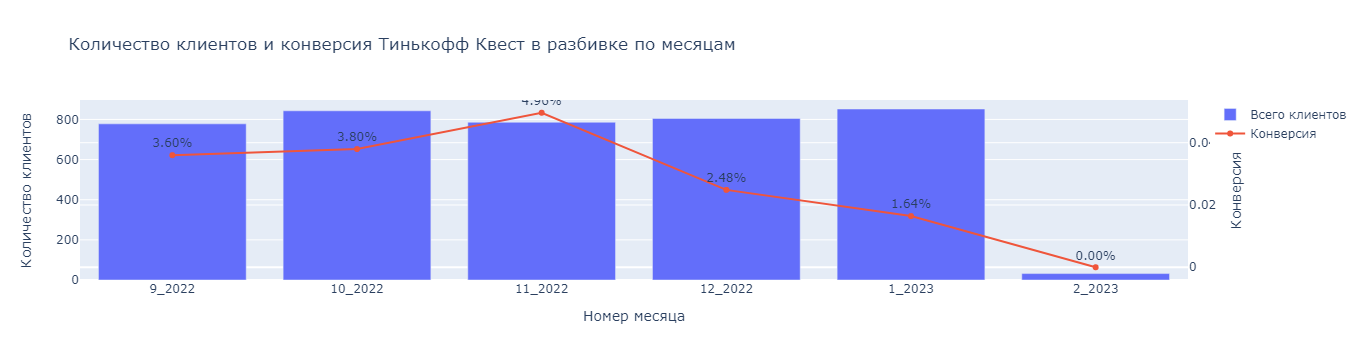

In [44]:
bar_chart = go.Bar(
    x=funnel_monthly['month_year'],
    y=funnel_monthly['client_rk'],
    name='Всего клиентов')

line_plot = go.Scatter(
    x=funnel_monthly['month_year'],
    y=funnel_monthly['conversion'],
    name='Конверсия',
    yaxis='y2',
    mode='lines+markers+text',
    hovertemplate='Конверсия: %{y:.2%}<extra></extra>',
    text = [f'{val:.2%}' for val in funnel_monthly['conversion']],
    textposition='top center')

layout = go.Layout(
    title='Количество клиентов и конверсия Тинькофф Квест в разбивке по месяцам',
    yaxis=dict(title='Количество клиентов'),
    xaxis_title='Номер месяца',
    yaxis2=dict(
        title='Конверсия',
        overlaying='y',
        side='right'))

fig = go.Figure(data=[bar_chart, line_plot], layout=layout)

fig.show()

Посещение сайта новыми клиентами сохранялось на уровне 800 человек в месяц. Наблюдается заметное падение месячной конверсии в декабре и январе до 1.64-2.48% вместо типичных показателей 3.6-5.0%.

[Назад к содержанию](#table_of_contents)

## Выводы <a class='anchor' id='final'></a>

В процессе исследования были сделаны следующие выводы:
1. Данные охватывают период с 1 сентября 2022 года по 2 февраля 2023 года.
2. Наибольшее количество клиентов теряется при визите на сайт - лишь 25% посетителей регистрируют аккаунт. Для решения этой проблемы необходимо стимулировать клиентов заводить аккаунт. Регистрация должна быть максимально простой и быстрой.
3. Лишь половина зарегистрировавшихся подают заявки на игры. Возможно, процесс подачи заявки также должна быть упрощена и ускорена.
4. Наибольшее число пройденых игр произошло в те недели, когда приток новых клиентов был максимальным - 39-40 и 44 недели 2022 года. В предновогодние недели приток посетителей сохранялся, но люди не проявляли интерес к играм. Новогодние праздники сильно уменьшили общую конверсию.
5. Значительное падение конверсии заметно начиная с 50-й недели (декабрь 2022 года) - с 5.36% до 2.0%. В новогодние праздники уровень посещения сайта новыми клиентами сохранялся на уровне 150-200 человек в день, но конверсия стабильно установилась на уровне 1.5-2.0%. На 5-й неделе 2023 года конверсия упала до 0 (февраль 2023). Максимальная конверсия в размере 6.11-7.11% наблюдалась в 38, 44 и 47 недели 2022 года.
6. В среднем месяцы сохраняли схожий уровень посещения по 780-850 человек в месяц. Структура воронок остается схожей и в новогодние месяцы. Данные за февраль имеют лишь два дня, поэтому представление воронки не репрезентативно.
7. Посещение сайта новыми клиентами сохранялось на уровне 800 человек в месяц. Наблюдается заметное падение месячной конверсии в декабре и январе до 1.64-2.48% вместо типичных показателей 3.6-5.0%.

[Назад к содержанию](#table_of_contents)